In [11]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2,RealAmplitudes

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from itertools import product
from scipy.optimize import minimize

In [7]:
noise = False 
n_qubits = 4
n_reps = 5
#nShots = 2**16
nShots = int(1e5)
print("nShots = ", nShots)

qc = QuantumCircuit(n_qubits)
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=n_reps, parameter_prefix='w')
parameters = list(ansatz.parameters)
qc.compose(ansatz, inplace=True)


nShots =  100000


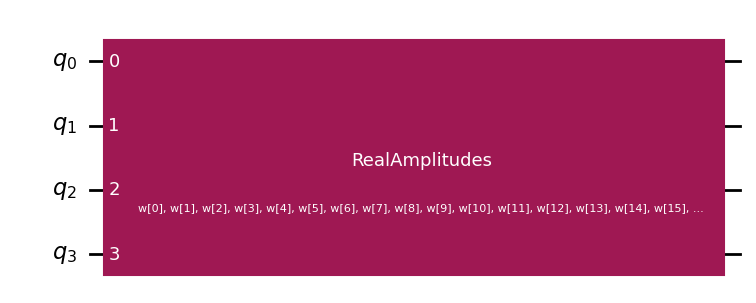

In [8]:
qc.draw('mpl')

In [24]:


aer = AerSimulator()

if noise:
    service = QiskitRuntimeService()
    real_backend = service.backend("ibm_kawasaki")
    aer = AerSimulator.from_backend(real_backend)
    estimator = Estimator(mode=aer)
    sampler = Sampler(mode = aer)
    pm = generate_preset_pass_manager(backend=aer, optimization_level=3)
    
else:
    
    estimator = Estimator( mode = aer)
    sampler = Sampler( mode = aer)
    
    pm = generate_preset_pass_manager(backend=aer, optimization_level=3)
    
isa_qc = pm.run(qc)

In [25]:


ob_list = []
for i in range(1,n_qubits,1):
    ob = SparsePauliOp.from_list([("I"*(i ) + "Z" + "I"* ( n_qubits - i-1), 1)])
    ob = ob.apply_layout(layout=isa_qc.layout)
    ob_list.append(ob)
    
    ob = SparsePauliOp.from_list([("I"*(i ) + "X" + "I"* ( n_qubits - i-1), 1)])
    ob = ob.apply_layout(layout=isa_qc.layout)
    ob_list.append(ob)
hamiltonian = sum(ob_list[1:], ob_list[0]) 


In [29]:
w = np.random.rand(len(qc.parameters))*2*np.pi

In [32]:
def loss(w):
    result = estimator.run([(isa_qc,hamiltonian,w)],precision = 0.005) # precision = 1 to sample only one time.
    evs = result.result()[0].data.evs
    return evs

In [33]:
loss(w)

array(-0.25435)

In [34]:
def train(maxiter=200):
    
    loss_history = []
    w = np.random.rand(len(qc.parameters))*2*np.pi

    def callback(theta):
        current_loss = loss(w)
        loss_history.append(current_loss)

    res = minimize(loss, w, method='COBYLA', callback=callback, options={'maxiter': maxiter})
    return res.x

In [52]:
class VQE():
    
    def __init__(self,n_qubits = 4, n_reps = 5,shots=2**15,seed=None,noise = None,w = None):
        self.n_qubits = n_qubits
        self.n_reps = n_reps
        self.shots = shots
        self.seed = seed
        self.noise = noise
        self.H = None
        self.loss_history = []
        
        
        self.qc = QuantumCircuit(n_qubits)
        ansatz = RealAmplitudes(num_qubits=n_qubits, reps=n_reps, parameter_prefix='w')
        parameters = list(ansatz.parameters)
        self.qc.compose(ansatz, inplace=True)
        self.isa_qc = None
        if w!= None:
            self.w = w
        else:
            self.w = np.random.rand(len(self.qc.parameters))*2*np.pi
        
    def transpile(self):

        aer = AerSimulator()

        if self.noise:
            service = QiskitRuntimeService()
            real_backend = service.backend("ibm_kawasaki")
            aer = AerSimulator.from_backend(real_backend)
            estimator = Estimator(mode=aer)
            sampler = Sampler(mode = aer)
            pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

        else:
            estimator = Estimator( mode = aer)
            sampler = Sampler( mode = aer)
            pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

            self.isa_qc = pm.run(self.qc) 
            
    def getH(self):
        ob_list = []
        for i in range(1,n_qubits,1):
            ob = SparsePauliOp.from_list([("I"*(i ) + "Z" + "I"* ( n_qubits - i-1), 1)])
            ob = ob.apply_layout(layout=isa_qc.layout)
            ob_list.append(ob)

            ob = SparsePauliOp.from_list([("I"*(i ) + "X" + "I"* ( n_qubits - i-1), 1)])
            ob = ob.apply_layout(layout=isa_qc.layout)
            ob_list.append(ob)
        hamiltonian = sum(ob_list[1:], ob_list[0]) 
        self.H = hamiltonian

        
    def loss(self,w):
        
        result = estimator.run([(self.isa_qc,self.H,w)],precision = 0.005) # precision = 1 to sample only one time.
        evs = result.result()[0].data.evs
        return evs
    
    def train(self, maxiter=100):
        w = self.w

        def callback(w):
            current_loss = self.loss(w)
            self.loss_history.append(current_loss)

        res = minimize(self.loss, w, method='COBYLA', callback=callback, options={'maxiter': maxiter})
        self.w = res.x
        return res.x



In [53]:
vqe = VQE()

In [54]:
vqe.transpile()

In [55]:
vqe.getH()

In [56]:
vqe.loss(vqe.w)

array(-0.1408)

In [57]:
vqe.train()

array([2.55245281, 4.45425567, 3.0535045 , 3.89646802, 6.18162833,
       2.87164431, 5.21225363, 1.65629534, 0.95897492, 2.91238712,
       1.83518984, 6.31496689, 2.47891247, 5.94782862, 3.03606927,
       5.02172832, 2.85797207, 2.42502942, 2.16084745, 1.22388631,
       1.06111434, 3.5226352 , 3.50289552, 6.86057381])

Text(0.5, 1.0, 'VQE COBYLA')

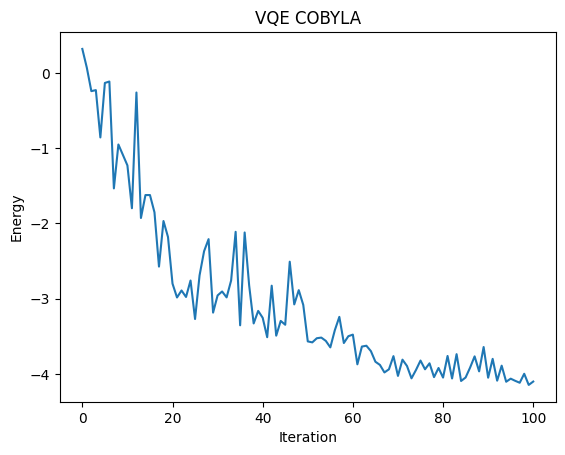

In [59]:
plt.plot(vqe.loss_history,label = "VQE")
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE COBYLA')